In [130]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split ##split the data
from sklearn.feature_selection import RFE ##Test Features and select the best ones
from sklearn.linear_model import LogisticRegression ##Test Features and select the best ones
import statsmodels.api as sm ##Stats
from sklearn.metrics import confusion_matrix ##F1 score
from sklearn import preprocessing ##Normalize feature
import missingno as msno 
import datetime as dt
from itertools import product
from pandas_profiling import ProfileReport
from datetime import datetime
import calendar
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [131]:
donors = pd.read_csv("donors.csv", low_memory= True)

In [132]:
donors = donors.drop(columns = 'Unnamed: 0', errors = 'ignore')

# Feature Selection

In [133]:
#Select demographic features for customer segmentation

In [134]:
#Delete neighborhood characteristics
neighborhood_columns = donors.loc[:, 'POP901':'AC2'].columns.to_list()
donors_selected = donors.copy()
donors_selected.drop(columns = neighborhood_columns, inplace = True)

# Feature Eng.

In [135]:
#Last promotion date
lastpromotiondate = datetime.strptime('2017-06-01', '%Y-%m-%d')
lastpromotiondate.year

2017

In [136]:
#Create Variable Age
donors_selected['DOB'] = donors_selected['DOB'].map(lambda x: datetime.strptime(x, '%Y-%m-%d') if pd.notnull(x) else x)
donors_selected['AGE'] = lastpromotiondate.year - donors_selected['DOB'].dt.year

In [137]:
#Create Function to count how many days to date.
def howmanydays(df, column, recent_year):
    df[column] = df[column].fillna('2017-06-01')
    df[column] = df[column].astype(str)
    df[column] = df[column].map(lambda x: datetime.strptime(x, '%Y-%m-%d') if pd.notnull(x) else x)
    df[column+'_days'] = (recent_year.
                       year - df[column].
                       dt.year)*12 + (recent_year.
                                      month - df[column].
                                      dt.month)

In [138]:
#Create Variable date_days for the date features.
for column in ['MAXADATE','MINRDATE','MAXRDATE','FISTDATE','NEXTDATE']:
    howmanydays(donors_selected, column, lastpromotiondate)

In [139]:
#Create Variables for RFM_Promotion

rdate = donors[['RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8','RDATE_9','RDATE_10','RDATE_11','RDATE_12','RDATE_13','RDATE_14','RDATE_15','RDATE_16','RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24']]
rdate.columns = ['16NK','16TK','16SK','16LL','16G1','16GK','16CC','16WL','16X1','16XK','15FS','15NK','15TK','15LL','15G1','15GK','15CC','15WL','15X1','15XK','14FS','14NK']
rdate = rdate #  Date the gift was received for 16NK

ramnt = donors[['RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9','RAMNT_10','RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20','RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24']]
ramnt.columns = ['16NK','16TK','16SK','16LL','16G1','16GK','16CC','16WL','16X1','16XK','15FS','15NK','15TK','15LL','15G1','15GK','15CC','15WL','15X1','15XK','14FS','14NK']
ramnt = ramnt  #Dollar amount of the gift for 16NK

In [140]:
#Take the last date that the donor sent a gift with the first non null value from rows.
lastgiftdate = []
for i in range(0,len(rdate)):
    if rdate.iloc[i].isnull().sum() == 22:
        lastgiftdate.append(0)
    else:
        lastgiftdate.append(rdate.iloc[i][rdate.iloc[i].notnull()][0])

In [141]:
#Add Columns
rdate['lastgiftdate'] = lastgiftdate

In [142]:
#Transforming to Datetime, if the customer didn't sent a gift go for 0.
rdate.loc[:,'lastgiftdate'] = rdate.loc[:,'lastgiftdate'].map(lambda x: datetime.strptime(x, '%Y-%m-%d')
                                                              if not isinstance(x, int) else 0)

In [143]:

#Recency: Last promotion date in months
lastpromotiondate = datetime.strptime('2017-06-01', '%Y-%m-%d')
Recency = []
for i in rdate['lastgiftdate']:
    if i == 0:
        Recency.append(None)
    else:
        Recency.append((lastpromotiondate.year - i.year)*12 + (lastpromotiondate.month - i.month))

In [144]:
# Monetary sum of all gifts from donors/rows
Monetary = ramnt.sum(axis=1)

In [145]:
#Frequency count of how many times the donor gifted.
Frequency = ramnt.count(axis=1)

In [146]:
#Create Columns from RFM
donors_selected['Recency'] = Recency
donors_selected['Frequency'] = Frequency
donors_selected['Monetary'] = Monetary

In [147]:
#Delete rows from non donors
delete_non_donors = donors_selected[donors_selected['Recency'].isnull()].index
# % of non_donors:
len(delete_non_donors)/len(donors_selected)

0.014075797593594097

In [148]:
donors_selected.drop(index = delete_non_donors, inplace = True)

In [149]:
#Create score Classification for RFM_Promotion
donors_selected['Recency_score'] = pd.qcut(donors_selected['Recency'].rank(method='first'), q=5 , labels= (5,4,3,2,1))
donors_selected['Recency_score'] = donors_selected['Recency_score'].astype(int)
donors_selected['Frequency_score'] = pd.qcut(donors_selected['Frequency'].rank(method='first'), q=5 , labels= range(1,6))
donors_selected['Frequency_score'] = donors_selected['Frequency_score'].astype(int)
donors_selected['Monetary_score'] = pd.qcut(donors_selected['Monetary'].rank(method='first'), q=5 , labels= range(1,6))
donors_selected['Monetary_score'] = donors_selected['Monetary_score'].astype(int)

In [150]:
#Create RFM from Lifetime donors_selected

donors_selected['Frequency_LTD'] = donors_selected['NGIFTALL']
donors_selected['Monetary_LTD'] = donors_selected['AVGGIFT']

In [151]:
#Transform LASTDATE to create Recency
donors_selected['LASTDATE'] = donors_selected['LASTDATE'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [152]:
#Create Recency from life time donors
lastpromotiondate = datetime.strptime('2017-06-01', '%Y-%m-%d')
lastpromotiondate.year
#Date associated with the most recent gift
donors_selected['Recency_LTD'] = (lastpromotiondate.year - donors_selected['LASTDATE']
                     .dt.year)*12 + (lastpromotiondate.month - donors_selected['LASTDATE']
                                                                              .dt.month)

In [153]:
#Create star Classification for RFM - LTD stands for Lifetime Donors
donors_selected['Recency_LTD_score'] = pd.qcut(donors_selected['Recency_LTD'].rank(method='first'), q=5 , labels= (5,4,3,2,1))
donors_selected['Recency_LTD_score'] = donors_selected['Recency_LTD_score'].astype(int)
donors_selected['Frequency_LTD_score'] = pd.qcut(donors_selected['Frequency_LTD'].rank(method='first'), q=5 , labels= range(1,6))
donors_selected['Frequency_LTD_score'] = donors_selected['Frequency_LTD_score'].astype(int)
donors_selected['Monetary_LTD_score'] = pd.qcut(donors_selected['Monetary_LTD'].rank(method='first'), q=5 , labels= range(1,6))
donors_selected['Monetary_LTD_score'] = donors_selected['Monetary_LTD_score'].astype(int)

In [154]:
#Create Variables sum and count for presents
def sum_by_column(df, new_col_name, list_of_cols_to_sum):
    df[new_col_name] = df[list_of_cols_to_sum].astype(float).sum(axis=1)
    return(df)

def count_by_column(df, new_col_name, list_of_cols_to_sum):
    df[new_col_name] = df[list_of_cols_to_sum].astype(float).count(axis=1)
    return(df)

In [155]:
GIFT = ramnt.copy()

# Aggregating by types and years
sum_by_column(GIFT, "16-labels", ['16LL','16WL'])
sum_by_column(GIFT, "15-labels", ['15LL','15WL'])
sum_by_column(GIFT, "16-calendars_with_stickers", ['16CC'])
sum_by_column(GIFT, "15-calendars_with_stickers", ['15CC'])
sum_by_column(GIFT, "15-blank_folding_cards_with_labels", ['15FS'])
sum_by_column(GIFT, "14-blank_folding_cards_with_labels", ['14FS'])
sum_by_column(GIFT, "16-blank_cards_with_labels", ['16NK','16SK'])
sum_by_column(GIFT, "15-blank_cards_with_labels", ['15NK'])
sum_by_column(GIFT, "14-blank_cards_with_labels", ['14NK'])
sum_by_column(GIFT, "16-thank_you_printed_with_labels", ['16TK'])
sum_by_column(GIFT, "15-thank_you_printed_with_labels", ['15TK'])
sum_by_column(GIFT, "16-general_greeting_cards_with_labels", ['16GK'])
sum_by_column(GIFT, "15-general_greeting_cards_with_labels", ['15GK'])
sum_by_column(GIFT, "16-christmas_cards_with_labels", ['16XK'])
sum_by_column(GIFT, "15-christmas_cards_with_labels", ['15XK'])
sum_by_column(GIFT, "16-notepad_with_labels", ['16X1','16G1'])
sum_by_column(GIFT, "15-notepad_with_labels", ['15X1','15G1'])

# Now summing by type of gift
sum_by_column(GIFT, "Just labels", ['16-labels','15-labels'])
sum_by_column(GIFT, "Calendars with stickers", ['16-calendars_with_stickers','15-calendars_with_stickers'])
sum_by_column(GIFT, "Blank folding cards with labels", ['15-blank_folding_cards_with_labels','14-blank_folding_cards_with_labels'])
sum_by_column(GIFT, "Blank cards with labels", ['16-blank_cards_with_labels','15-blank_cards_with_labels', '14-blank_cards_with_labels'])
sum_by_column(GIFT, "Thank you cards with labels", ['16-thank_you_printed_with_labels', '15-thank_you_printed_with_labels','16-general_greeting_cards_with_labels','15-general_greeting_cards_with_labels'])
sum_by_column(GIFT, "Christmas Cards with labels", ['16-christmas_cards_with_labels', '15-christmas_cards_with_labels'])
sum_by_column(GIFT, "General Greeting Cards with Labels", ['16-general_greeting_cards_with_labels','15-general_greeting_cards_with_labels'])
sum_by_column(GIFT, "Notepad with labels", ['16-notepad_with_labels', '15-notepad_with_labels'])

GIFT_sum = GIFT.iloc[:,-8:]

In [156]:
GIFT = ramnt.copy()

# Aggregating by types and years
count_by_column(GIFT, "16-labels", ['16LL','16WL'])
count_by_column(GIFT, "15-labels", ['15LL','15WL'])
count_by_column(GIFT, "16-calendars_with_stickers", ['16CC'])
count_by_column(GIFT, "15-calendars_with_stickers", ['15CC'])
count_by_column(GIFT, "15-blank_folding_cards_with_labels", ['15FS'])
count_by_column(GIFT, "14-blank_folding_cards_with_labels", ['14FS'])
count_by_column(GIFT, "16-blank_cards_with_labels", ['16NK','16SK'])
count_by_column(GIFT, "15-blank_cards_with_labels", ['15NK'])
count_by_column(GIFT, "14-blank_cards_with_labels", ['14NK'])
count_by_column(GIFT, "16-thank_you_printed_with_labels", ['16TK'])
count_by_column(GIFT, "15-thank_you_printed_with_labels", ['15TK'])
count_by_column(GIFT, "16-general_greeting_cards_with_labels", ['16GK'])
count_by_column(GIFT, "15-general_greeting_cards_with_labels", ['15GK'])
count_by_column(GIFT, "16-christmas_cards_with_labels", ['16XK'])
count_by_column(GIFT, "15-christmas_cards_with_labels", ['15XK'])
count_by_column(GIFT, "16-notepad_with_labels", ['16X1','16G1'])
count_by_column(GIFT, "15-notepad_with_labels", ['15X1','15G1'])

# Now summing by type of gift
sum_by_column(GIFT, "Just labels_count", ['16-labels','15-labels'])
sum_by_column(GIFT, "Calendars with stickers_count", ['16-calendars_with_stickers','15-calendars_with_stickers'])
sum_by_column(GIFT, "Blank folding cards with labels_count", ['15-blank_folding_cards_with_labels','14-blank_folding_cards_with_labels'])
sum_by_column(GIFT, "Blank cards with labels_count", ['16-blank_cards_with_labels','15-blank_cards_with_labels', '14-blank_cards_with_labels'])
sum_by_column(GIFT, "Thank you cards with labels_count", ['16-thank_you_printed_with_labels', '15-thank_you_printed_with_labels','16-general_greeting_cards_with_labels','15-general_greeting_cards_with_labels'])
sum_by_column(GIFT, "Christmas Cards with labels_count", ['16-christmas_cards_with_labels', '15-christmas_cards_with_labels'])
sum_by_column(GIFT, "General Greeting Cards with Labels_count", ['16-general_greeting_cards_with_labels','15-general_greeting_cards_with_labels'])
sum_by_column(GIFT, "Notepad with labelss_count", ['16-notepad_with_labels', '15-notepad_with_labels'])

GIFT_count = GIFT.iloc[:,-8:]

In [157]:
donors_selected = pd.concat([donors_selected, GIFT_sum, GIFT_count], axis = 1)

In [158]:
#Delete non donors Ids after gift table.
donors_selected.drop(index = delete_non_donors, inplace = True)

# Feature Selection for segmentation

In [159]:
donors_selected.loc[:, 'COLLECT1':'PLATES'].columns

Index(['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY',
       'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS',
       'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES'],
      dtype='object')

In [160]:
non_related_columns = ['ODATEDW','OSOURCE', 'TCODE', 'STATE', 'ZIP','MAILCODE', 'DOB', 'NOEXCH', 'RECINHSE', 
                       'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'DOMAIN', 'HOMEOWNR', 'CHILD03', 'CHILD07', 
                       'CHILD12', 'CHILD18', 'NUMCHLD', 'MBCOLECT','PUBDOITY', 'PUBGARDN', 'PUBHLTH', 'MAGMALE','PUBNEWFN', 
                       'PUBPHOTO', 'PUBOPP', 'MAGFEM', 'MAGFAML', 'MBBOOKS','MBGARDEN', 'WWIIVETS',
                       'MBCRAFT', 'PUBCULIN', 'DATASRCE', 'MALEMILI', 'MALEVET', 'VIETVETS','LIFESRC', 'LOCALGOV',
                       'STATEGOV', 'FEDGOV', 'GEOCODE','COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY',
                       'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS',
                       'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES']

RFA_columns_delete = donors_selected.columns[donors_selected.columns.str.contains('RFA_')].to_list()
RAMNT_columns_delete = donors_selected.columns[donors_selected.columns.str.contains('RAMNT_')].to_list()
RDATE_columns_delete = donors_selected.columns[donors_selected.columns.str.contains('RDATE_')].to_list()
ADATA_columns_delete = donors_selected.columns[donors_selected.columns.str.contains('ADATE_')].to_list()
MDMAUD_columns_delete = donors_selected.columns[donors_selected.columns.str.contains('MDMAUD_')].to_list()

delete_columns = non_related_columns+RFA_columns_delete+RAMNT_columns_delete+RDATE_columns_delete+ADATA_columns_delete+MDMAUD_columns_delete

delete_columns.remove('MINRDATE_days')
delete_columns.remove('MAXRDATE_days')
delete_columns.remove('MAXADATE_days')

In [161]:
donors_segmentation = donors_selected.drop(columns = delete_columns)

In [162]:
#Delete date columns
date_columns = ['MAXADATE','MINRDATE','MAXRDATE','FISTDATE','NEXTDATE']

In [163]:
donors_segmentation.drop(columns = date_columns, inplace = True)

In [164]:
#Delete RFM life time columns
rfm_lft_columns = ['NGIFTALL', 'AVGGIFT', 'LASTDATE']

In [165]:
donors_segmentation.drop(columns = rfm_lft_columns, inplace = True)

In [166]:
#Delete TIMELAG since there are donors without a second gift
timelag_column = ['TIMELAG']

In [167]:
donors_segmentation.drop(columns = timelag_column, inplace = True)

In [168]:
#Delete control number
control_number = ['CONTROLN']

In [169]:
donors_segmentation.drop(columns = control_number, inplace = True)

In [170]:
HPHONE_D = ['HPHONE_D']

In [171]:
donors_segmentation.drop(columns = HPHONE_D, inplace = True)

In [172]:
country_size = ['GEOCODE2']

In [173]:
donors_segmentation.drop(columns = country_size, inplace = True)

In [174]:
#Lifetime information delete:
life_time_columns = ['RAMNTALL', 'Frequency_LTD', 'CARDGIFT','Monetary_LTD', 'Recency_LTD', 
                     'Recency_LTD_score', 'Frequency_LTD_score','Monetary_LTD_score']

In [175]:
donors_segmentation.drop(columns = life_time_columns, inplace = True)

In [176]:
PVASTATE = ['PVASTATE']

In [177]:
donors_segmentation.drop(columns = PVASTATE, inplace = True)

In [178]:
#Delete SOLIH and SOLP3, too little information
SOLIH_SOLP3 = ['SOLIH', 'SOLP3']

In [179]:
donors_segmentation.drop(columns = SOLIH_SOLP3, inplace = True)

# OHE

In [180]:
nonmetric_features = donors_segmentation.dtypes[(donors_segmentation.dtypes == 'object')].index.to_list()
metric_features = donors_segmentation.dtypes[(donors_segmentation.dtypes != 'object')].index.to_list()

In [181]:
nonmetric_features

['GENDER', 'MAJOR', 'PEPSTRFL']

In [182]:
donors_segmentation['GENDER'].replace('J', 'U', inplace = True)
donors_segmentation['GENDER'].replace('A', 'U', inplace = True)
donors_segmentation['GENDER'].replace('C', 'U', inplace = True)
donors_segmentation['GENDER'].replace(' ', 'U', inplace = True)

In [183]:
donors_segmentation['MAJOR'].replace('X', 'MAJOR', inplace = True)

In [184]:
donors_segmentation['PEPSTRFL'].replace('X', 'PEPSTRFL', inplace = True)

In [185]:
train_data_standard_ohe = donors_segmentation.copy()
ohc = OneHotEncoder(sparse=False, drop = 'if_binary')
ohc_feat = ohc.fit_transform(train_data_standard_ohe[nonmetric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=train_data_standard_ohe[nonmetric_features].index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df.head()

,x0_F,x0_M,x0_U,x1_MAJOR,x2_PEPSTRFL
0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0


In [186]:
donors_segmentation = pd.concat([donors_segmentation[metric_features],
                            ohc_df],
                           axis = 1)

# Fill NaN

In [187]:
imputer = KNNImputer(n_neighbors=8, weights="uniform")
fill_na = imputer.fit_transform(donors_segmentation)

In [188]:
donors_seg_fillnan = donors_segmentation.copy()

In [189]:
donors_seg_fillnan.iloc[:,:] = fill_na

In [190]:
donors_seg_fillnan['INCOME'] = round(donors_seg_fillnan['INCOME'],0)
donors_seg_fillnan['WEALTH1'] = round(donors_seg_fillnan['WEALTH1'],0)
donors_seg_fillnan['WEALTH2'] = round(donors_seg_fillnan['WEALTH2'],0)
donors_seg_fillnan['AGE'] = round(donors_seg_fillnan['AGE'],0)

In [191]:
# Delete donors with age lower than 18
drop_age = donors_seg_fillnan[donors_seg_fillnan['AGE'] < 18].index.to_list()
donors_seg_fillnan.drop(index = drop_age, inplace = True)

In [192]:
donors_seg_fillnan

,INCOME,WEALTH1,HIT,WEALTH2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,MINRAMNT,MAXRAMNT,...,Blank cards with labels_count,Thank you cards with labels_count,Christmas Cards with labels_count,General Greeting Cards with Labels_count,Notepad with labelss_count,x0_F,x0_M,x0_U,x1_MAJOR,x2_PEPSTRFL
0,4.0,6.0,0.0,5.0,27.0,74.0,6.0,14.0,5.0,12.0,...,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,6.0,9.0,16.0,9.0,12.0,32.0,6.0,13.0,10.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.0,1.0,2.0,1.0,26.0,63.0,6.0,14.0,2.0,16.0,...,2.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,4.0,2.0,0.0,27.0,66.0,6.0,14.0,2.0,11.0,...,1.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0
4,3.0,2.0,60.0,6.0,43.0,113.0,10.0,25.0,3.0,15.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,3.0,3.0,0.0,5.0,6.0,14.0,5.0,12.0,25.0,25.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
95408,7.0,9.0,1.0,6.0,4.0,10.0,3.0,8.0,20.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
95409,4.0,4.0,0.0,3.0,14.0,33.0,7.0,17.0,3.0,10.0,...,0.0,2.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
95410,7.0,6.0,0.0,7.0,36.0,127.0,9.0,31.0,5.0,21.0,...,0.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0


In [193]:
# model specification
model1 = LocalOutlierFactor(n_neighbors = 8)
# model fitting
y_pred = model1.fit_predict(donors_seg_fillnan)

In [194]:
# filter outlier index
outlier_index = (y_pred == -1) # negative values are outliers and positives inliers
# filter outlier values
outlier_values = donors_seg_fillnan.iloc[outlier_index]

In [195]:
donors_seg_outlier = donors_seg_fillnan.copy()

In [196]:
#Delete Outliers to fill NaN
donors_seg_outlier.drop(index = outlier_values.index, inplace = True)

In [197]:
low_cor = donors_seg_outlier.corr().loc[:,['Recency_score','Frequency_score', 'Monetary_score']].pow(2).sum(axis= 1).sort_values().head(10)
high_cor = donors_seg_outlier.corr().loc[:,['Recency_score','Frequency_score', 'Monetary_score']].pow(2).sum(axis= 1).sort_values().tail(10)

In [198]:
high_cor

Blank folding cards with labels_count    0.301914
Thank you cards with labels_count        0.321831
Blank cards with labels_count            0.340898
CARDPM12                                 0.355335
Monetary                                 0.743032
Recency                                  0.900514
Recency_score                            1.036779
Frequency                                1.101556
Monetary_score                           1.383943
Frequency_score                          1.412330
dtype: float64

In [199]:
low_cor

MAXADATE_days    0.000148
x0_U             0.000149
HIT              0.000182
x0_F             0.001241
x0_M             0.001416
WEALTH2          0.003252
x1_MAJOR         0.004184
WEALTH1          0.004397
INCOME           0.007763
AGE              0.010274
dtype: float64

In [200]:
#Delete low and high corr
corr_filter = ['AGE', 'INCOME', 'WEALTH1', 'WEALTH2', 'HIT', 'MAXADATE_days','Monetary','Recency','Frequency']

In [201]:
donors_seg_fsel = donors_seg_outlier.copy()

In [202]:
donors_seg_fsel.drop(columns = corr_filter, inplace = True)

In [203]:
nonmetric_features = donors_seg_fsel.dtypes[(donors_seg_fsel.dtypes == 'object')].index.to_list()
metric_features = donors_seg_fsel.dtypes[(donors_seg_fsel.dtypes != 'object')].index.to_list()

# Scale Data

In [204]:
donors_seg_scaled = donors_seg_fsel.copy()

In [205]:
# Use MinMaxScaler to scale the data
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(donors_seg_scaled[metric_features])
scaled_feat

array([[ 0.9891056 ,  1.18510958,  0.52265864, ..., -0.23605993,
        -0.05161732,  1.03458209],
       [-0.77843073, -0.67446773,  0.52265864, ..., -0.23605993,
        -0.05161732, -0.96657386],
       [ 0.87126985,  0.69807743,  0.52265864, ..., -0.23605993,
        -0.05161732,  1.03458209],
       ...,
       [-0.54275922, -0.63019208,  1.35321255, ..., -0.23605993,
        -0.05161732,  1.03458209],
       [ 2.0496274 ,  3.53171905,  3.01432039, ..., -0.23605993,
        -0.05161732,  1.03458209],
       [ 1.57828438,  4.06302686,  0.52265864, ..., -0.23605993,
        19.3733437 ,  1.03458209]])

In [206]:
donors_seg_scaled[metric_features] = scaled_feat
donors_seg_scaled.head()

,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,MINRAMNT,MAXRAMNT,LASTGIFT,MINRDATE_days,MAXRDATE_days,FISTDATE_days,...,Blank cards with labels_count,Thank you cards with labels_count,Christmas Cards with labels_count,General Greeting Cards with Labels_count,Notepad with labelss_count,x0_F,x0_M,x0_U,x1_MAJOR,x2_PEPSTRFL
0,0.989106,1.185110,0.522659,0.275884,-0.376313,-0.549768,-0.596883,0.107863,0.445676,0.594068,...,2.499378,0.702874,-0.788490,-0.736488,0.815105,0.926664,-0.832252,-0.23606,-0.051617,1.034582
1,-0.778431,-0.674468,0.522659,0.046195,0.337775,0.402689,0.677538,-0.333614,-0.633548,-0.667494,...,-0.711139,-0.759676,-0.788490,-0.736488,-0.685631,-1.079140,1.201559,-0.23606,-0.051617,-0.966574
2,0.871270,0.698077,0.522659,0.275884,-0.804765,-0.256704,-1.021690,0.391669,1.377734,0.540384,...,2.499378,0.702874,2.374257,0.944448,-0.685631,-1.079140,1.201559,-0.23606,-0.051617,1.034582
3,0.989106,0.830904,0.522659,0.275884,-0.804765,-0.623034,-0.596883,1.905302,0.004176,1.479845,...,0.894119,-0.759676,0.792883,-0.736488,3.816578,0.926664,-0.832252,-0.23606,-0.051617,1.034582
4,2.874478,2.911860,3.844874,2.802471,-0.661948,-0.329970,-0.172076,-0.333614,-0.682603,4.029810,...,0.894119,0.702874,-0.788490,0.944448,-0.685631,0.926664,-0.832252,-0.23606,-0.051617,-0.966574


# PCA

In [207]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(donors_seg_scaled[metric_features])
pca_feat

array([[ 3.72108274e+00,  7.78750306e-01, -3.10650775e-01, ...,
        -2.09040600e-01, -2.60049593e-02, -1.07171490e-15],
       [-1.86679454e+00, -8.54915668e-01,  1.18481732e+00, ...,
        -6.55181900e-02,  1.51713393e-01,  3.27129563e-15],
       [ 3.51648498e+00,  1.61738647e+00, -9.72186385e-01, ...,
         1.43439460e-01,  1.00778123e-01,  5.25733566e-16],
       ...,
       [-3.17012811e-01,  4.22460420e+00, -1.96437434e+00, ...,
         1.19834547e-01, -1.70851378e-02, -3.95303381e-17],
       [ 6.82187084e+00,  4.88778867e+00,  1.81795632e+00, ...,
        -6.26243664e-01,  8.42402579e-02, -1.36831979e-16],
       [ 6.94185498e+00,  2.48340271e+00,  2.25406860e+01, ...,
        -4.95423013e-01,  1.16940608e-01, -9.65934214e-18]])

In [254]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
).head(25)

,Eigenvalue,Difference,Proportion,Cumulative
1,5.914333,0.000000,0.197142,0.197142
2,4.004780,-1.909553,0.133491,0.330633
3,2.907329,-1.097451,0.096910,0.427543
4,2.552182,-0.355147,0.085072,0.512615
5,2.002786,-0.549396,0.066759,0.579374
6,1.894548,-0.108238,0.063151,0.642525
7,1.772564,-0.121984,0.059085,0.701610
8,1.601062,-0.171502,0.053368,0.754978
9,1.455852,-0.145210,0.048528,0.803506
10,1.169595,-0.286257,0.038986,0.842492


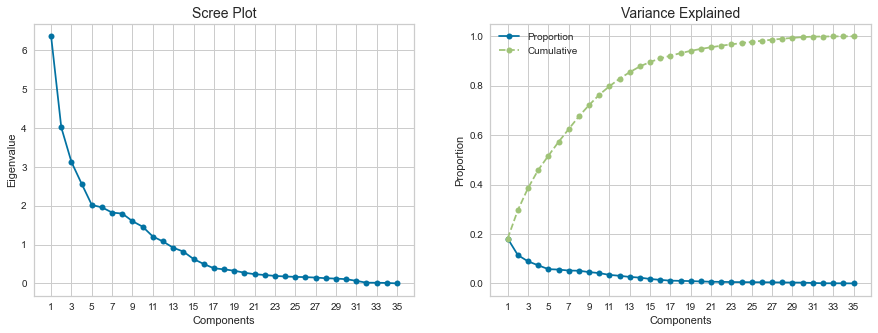

In [209]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [248]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=25)
pca_feat = pca.fit_transform(donors_seg_scaled[metric_features])

In [249]:
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

In [250]:
df_pca = donors_seg_scaled.copy()

In [251]:
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,3.555912,0.834114,-0.071340,-2.292399,0.801202,-2.387789,-1.115864,1.192207,-0.457978,0.048485,...,0.229541,-0.140280,0.272181,-0.416957,0.271258,-0.064754,-0.837130,-0.374837,0.905524,-0.266055
1,-1.551436,-0.859325,1.068433,-0.320003,0.899953,1.870315,-2.205084,-0.962251,-0.278037,-0.547488,...,0.081193,0.122176,0.035758,-0.211611,0.098163,0.387810,-0.519109,0.081351,0.062030,-0.097493
2,3.337287,1.700676,-1.019050,-2.031367,-2.717503,-1.082204,0.668977,0.136173,-0.258062,0.406769,...,-0.084217,0.224707,0.779676,0.294179,-0.173396,0.202231,-0.687825,-0.134267,-0.377745,0.606654
3,4.016316,-1.059596,0.226402,-1.548674,2.970470,-1.482693,1.974760,-0.611563,-1.312015,1.906179,...,-0.173992,0.878016,-0.108445,-0.618818,0.068668,0.659828,-0.196854,0.081391,-0.074080,0.000668
4,5.401586,0.370591,-0.560691,3.570375,-0.147861,0.067712,1.095132,0.530366,-1.771907,-4.167804,...,2.155406,-1.558727,-1.061009,0.375693,0.074001,-0.145841,-0.071539,-0.511462,-0.304012,-0.254825


In [252]:
# Reassigning df to contain pca variables
donors_seg_pca = pd.concat([donors_seg_scaled, pca_df], axis=1)
donors_seg_pca.head()

,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,MINRAMNT,MAXRAMNT,LASTGIFT,MINRDATE_days,MAXRDATE_days,FISTDATE_days,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,0.989106,1.185110,0.522659,0.275884,-0.376313,-0.549768,-0.596883,0.107863,0.445676,0.594068,...,0.229541,-0.140280,0.272181,-0.416957,0.271258,-0.064754,-0.837130,-0.374837,0.905524,-0.266055
1,-0.778431,-0.674468,0.522659,0.046195,0.337775,0.402689,0.677538,-0.333614,-0.633548,-0.667494,...,0.081193,0.122176,0.035758,-0.211611,0.098163,0.387810,-0.519109,0.081351,0.062030,-0.097493
2,0.871270,0.698077,0.522659,0.275884,-0.804765,-0.256704,-1.021690,0.391669,1.377734,0.540384,...,-0.084217,0.224707,0.779676,0.294179,-0.173396,0.202231,-0.687825,-0.134267,-0.377745,0.606654
3,0.989106,0.830904,0.522659,0.275884,-0.804765,-0.623034,-0.596883,1.905302,0.004176,1.479845,...,-0.173992,0.878016,-0.108445,-0.618818,0.068668,0.659828,-0.196854,0.081391,-0.074080,0.000668
4,2.874478,2.911860,3.844874,2.802471,-0.661948,-0.329970,-0.172076,-0.333614,-0.682603,4.029810,...,2.155406,-1.558727,-1.061009,0.375693,0.074001,-0.145841,-0.071539,-0.511462,-0.304012,-0.254825


In [253]:
donors_seg_pca.to_csv(os.path.join("donors_final.csv"), index=True)

# Clustering

In [261]:
# Splitting feature names into groups
non_metric_features = donors_seg_pca.columns[donors_seg_pca.columns.str.startswith('x')].to_list()
pc_features = donors_seg_pca.columns[donors_seg_pca.columns.str.startswith('PC')].to_list()
metric_features = donors_seg_pca.columns[~donors_seg_pca.columns.str.startswith('x') & ~donors_seg_pca.columns.str.startswith('PC')].to_list()

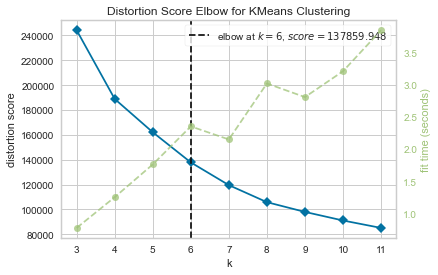

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [217]:
X = donors_seg_outlier.loc[:,['Recency_score','Frequency_score', 'Monetary_score']]
kelbow_visualizer(KMeans(init='k-means++', n_init=15, max_iter=300, random_state=1), X, k=(3,12),
                 timing = False)

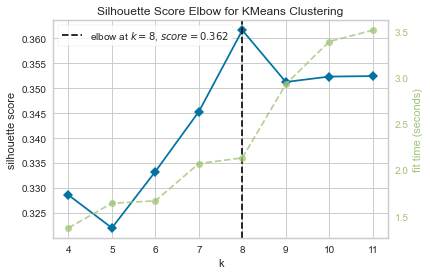

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [218]:
X = donors_seg_outlier.loc[:,['Recency_score','Frequency_score', 'Monetary_score']]
model = KMeans(init='k-means++', n_init=15, max_iter=300, random_state=1)
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='silhouette', timing = False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [262]:
kmeans_pca = KMeans(init='k-means++', n_clusters=8, n_init=15, max_iter=300, random_state=1)
kmeans_pca.fit(donors_seg_pca.loc[:,pc_features + non_metric_features])

KMeans(n_init=15, random_state=1)

In [263]:
kmeans_pcaselected = KMeans(init='k-means++', n_clusters=8, n_init=15, max_iter=300, random_state=1)
kmeans_pcaselected.fit(donors_seg_pca.loc[:,['PC1','PC0','PC3']])

KMeans(n_init=15, random_state=1)

In [264]:
kmeans_rfm = KMeans(init='k-means++', n_clusters=8, n_init=15, max_iter=300, random_state=1)
kmeans_rfm.fit(donors_seg_outlier.loc[:,['Recency_score','Frequency_score', 'Monetary_score']])

KMeans(n_init=15, random_state=1)

In [265]:
kmeans_all = KMeans(init='k-means++', n_clusters=8, n_init=15, max_iter=300, random_state=1)
kmeans_all.fit(donors_seg_pca.loc[:,metric_features + non_metric_features])

KMeans(n_init=15, random_state=1)

In [266]:
decision_tree = donors_seg_pca
decision_tree['Cluster_RFM'] = kmeans_pca.labels_
# Preparing the data
X = decision_tree.drop(columns=['Cluster_RFM'])
y = decision_tree['Cluster_RFM']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending = False).head(6)

It is estimated that in average, we are able to predict 72.99% of the customers correctly


General Greeting Cards with Labels    0.244731
PC0                                   0.242495
PC1                                   0.218954
PC3                                   0.176050
Calendars with stickers               0.117770
PC24                                  0.000000
dtype: float64

In [267]:
decision_tree = donors_seg_pca
decision_tree['Cluster_RFM'] = kmeans_pcaselected.labels_
# Preparing the data
X = decision_tree.drop(columns=['Cluster_RFM'])
y = decision_tree['Cluster_RFM']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending = False).head(6)

It is estimated that in average, we are able to predict 68.04% of the customers correctly


General Greeting Cards with Labels    0.391714
PC0                                   0.354233
PC1                                   0.219596
PC3                                   0.034457
PC24                                  0.000000
Calendars with stickers               0.000000
dtype: float64

In [268]:
decision_tree = donors_seg_pca
decision_tree['Cluster_RFM'] = kmeans_rfm.labels_
# Preparing the data
X = decision_tree.drop(columns=['Cluster_RFM'])
y = decision_tree['Cluster_RFM']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending = False).head(6)
                          

It is estimated that in average, we are able to predict 85.59% of the customers correctly


Recency_score                        0.498527
Frequency_score                      0.340631
Monetary_score                       0.160842
PC24                                 0.000000
Blank folding cards with labels      0.000000
Christmas Cards with labels_count    0.000000
dtype: float64

In [269]:
decision_tree = donors_seg_pca
decision_tree['Cluster_RFM'] = kmeans_all.labels_
# Preparing the data
X = decision_tree.drop(columns=['Cluster_RFM'])
y = decision_tree['Cluster_RFM']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending = False).head(6)

It is estimated that in average, we are able to predict 76.96% of the customers correctly


PC0                                         0.253806
General Greeting Cards with Labels_count    0.231344
PC3                                         0.208629
CARDPROM                                    0.164312
Frequency_score                             0.125385
Thank you cards with labels                 0.016526
dtype: float64

# Cluster Analysis

In [227]:
#The best score was with de RFM variables, 85.59%.
kmeans = KMeans(init='k-means++', n_clusters=8, n_init=15, max_iter=300, random_state=1)
kmeans.fit(donors_seg_outlier.loc[:,['Recency_score','Frequency_score', 'Monetary_score']])

KMeans(n_init=15, random_state=1)

In [273]:
donors_seg_outlier.columns

Index(['INCOME', 'WEALTH1', 'HIT', 'WEALTH2', 'CARDPROM', 'NUMPROM',
       'CARDPM12', 'NUMPRM12', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'AGE',
       'MAXADATE_days', 'MINRDATE_days', 'MAXRDATE_days', 'FISTDATE_days',
       'NEXTDATE_days', 'Recency', 'Frequency', 'Monetary', 'Recency_score',
       'Frequency_score', 'Monetary_score', 'Just labels',
       'Calendars with stickers', 'Blank folding cards with labels',
       'Blank cards with labels', 'Thank you cards with labels',
       'Christmas Cards with labels', 'General Greeting Cards with Labels',
       'Notepad with labels', 'Just labels_count',
       'Calendars with stickers_count',
       'Blank folding cards with labels_count',
       'Blank cards with labels_count', 'Thank you cards with labels_count',
       'Christmas Cards with labels_count',
       'General Greeting Cards with Labels_count',
       'Notepad with labelss_count', 'x0_F', 'x0_M', 'x0_U', 'x1_MAJOR',
       'x2_PEPSTRFL', 'Cluster_RFM', 'Customer_RFM']

In [228]:
donors_seg_outlier['Cluster_RFM'] = kmeans.labels_

In [229]:
# Create RFM Table from cluster
RFM = donors_seg_outlier.loc[:,['Recency_score','Frequency_score', 'Monetary_score','Cluster_RFM']].groupby(['Cluster_RFM']).agg(['mean'])

In [230]:
RFM['Total'] = RFM.sum(axis = 1)

In [231]:
round(RFM.sort_values(by = 'Total', ascending = False),2)

,Recency_score,Frequency_score,Monetary_score,Total
,mean,mean,mean,
Cluster_RFM,,,,
0,4.56,4.54,4.59,13.70
5,2.14,4.43,4.59,11.17
2,4.58,4.03,2.39,11.00
3,3.75,2.45,3.73,9.92
7,2.43,3.98,2.28,8.69
1,1.35,2.55,3.50,7.40
4,4.01,1.41,1.40,6.82
6,1.44,1.36,1.36,4.16


In [295]:
donors_seg_outlier['Customer_RFM']

0        1
1        4
2        2
3        1
4        7
        ..
95407    7
95408    7
95409    3
95410    1
95411    2
Name: Customer_RFM, Length: 91071, dtype: object

In [296]:
bins = [0,5,2,3,7,1,4,6]
labels = ['8','7','6','5','4','3','2','1']
donors_seg_outlier['Customer_RFM'] = donors_seg_outlier['Cluster_RFM'].map(dict(zip(bins, labels)))


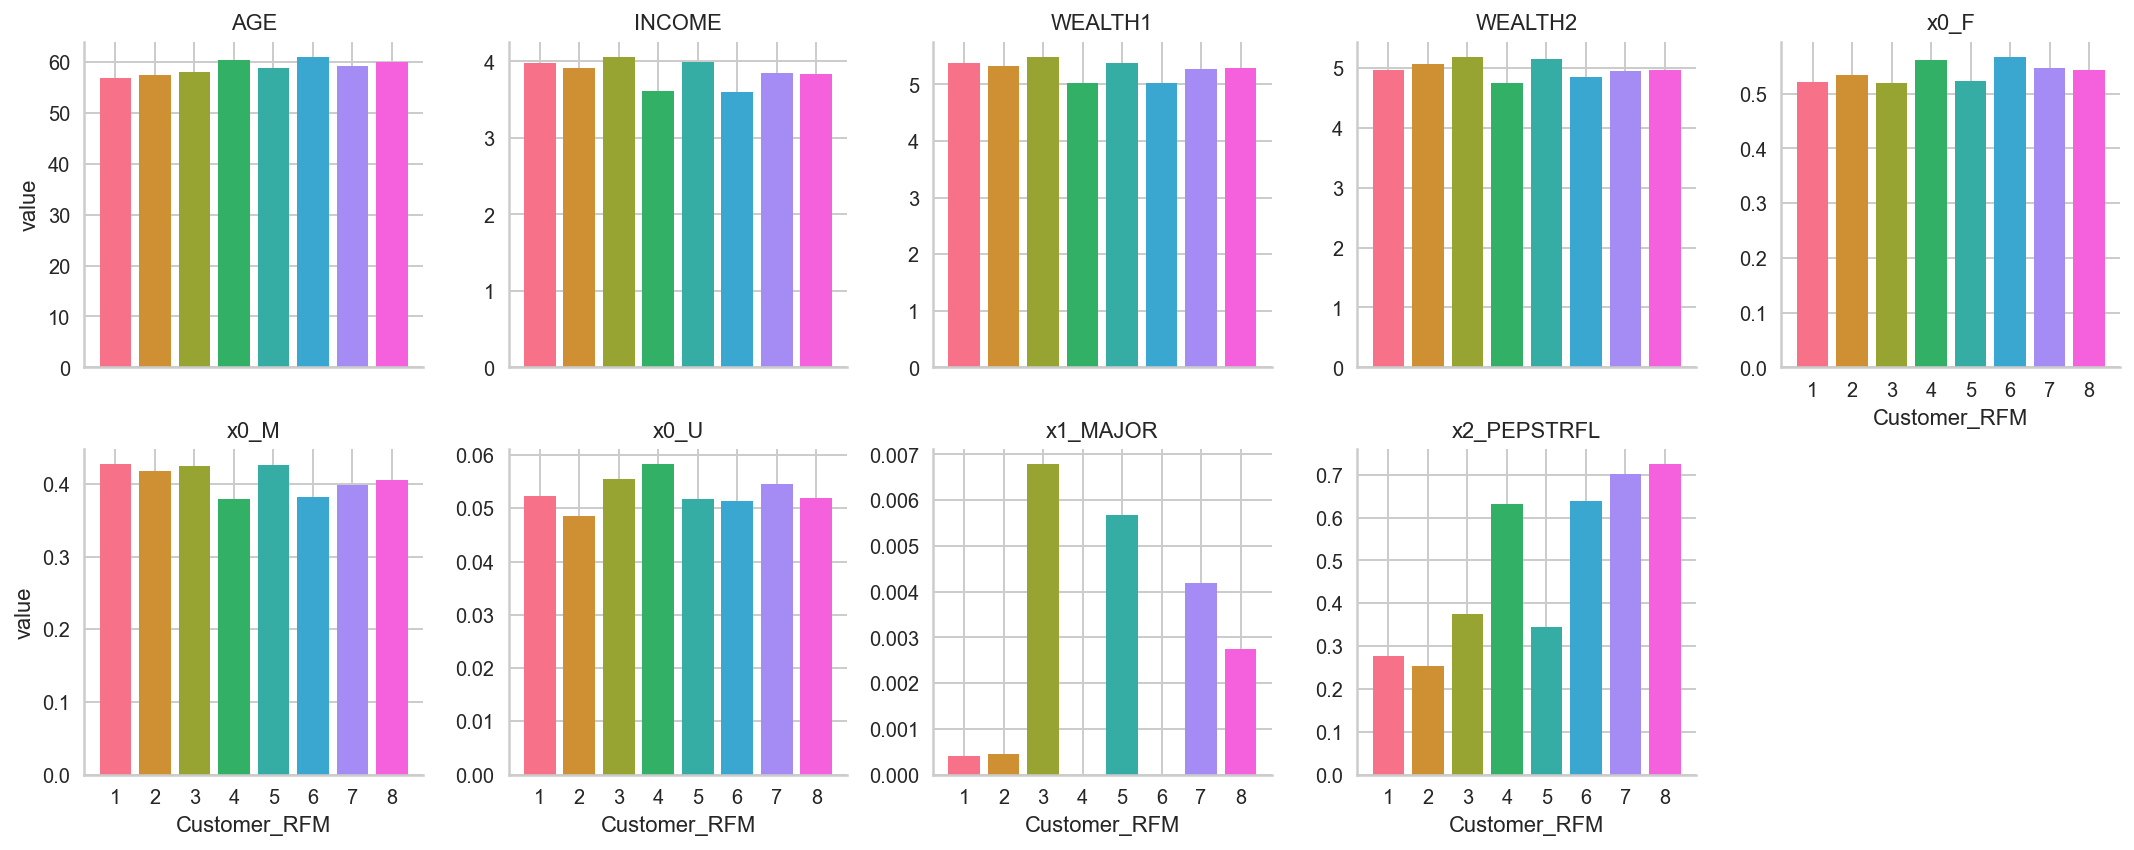

In [297]:
#Demographic Analysis
demographic = ['INCOME', 'WEALTH1', 'WEALTH2', 'AGE', 'x0_F','x0_M', 'x0_U', 'x1_MAJOR', 'x2_PEPSTRFL', 'Customer_RFM']

df = donors_seg_outlier[demographic].copy()
df = df.reset_index()
df = df.melt(id_vars=['index', 'Customer_RFM'])
df = df.set_index('index', drop = True)
df = df.groupby(['Customer_RFM', 'variable']).mean().reset_index()
g = sns.FacetGrid(df, col='variable', hue='Customer_RFM', col_wrap=5, height=3, sharey=False, legend_out=False)
g = g.map(plt.bar, 'Customer_RFM', 'value').set_titles("{col_name}");

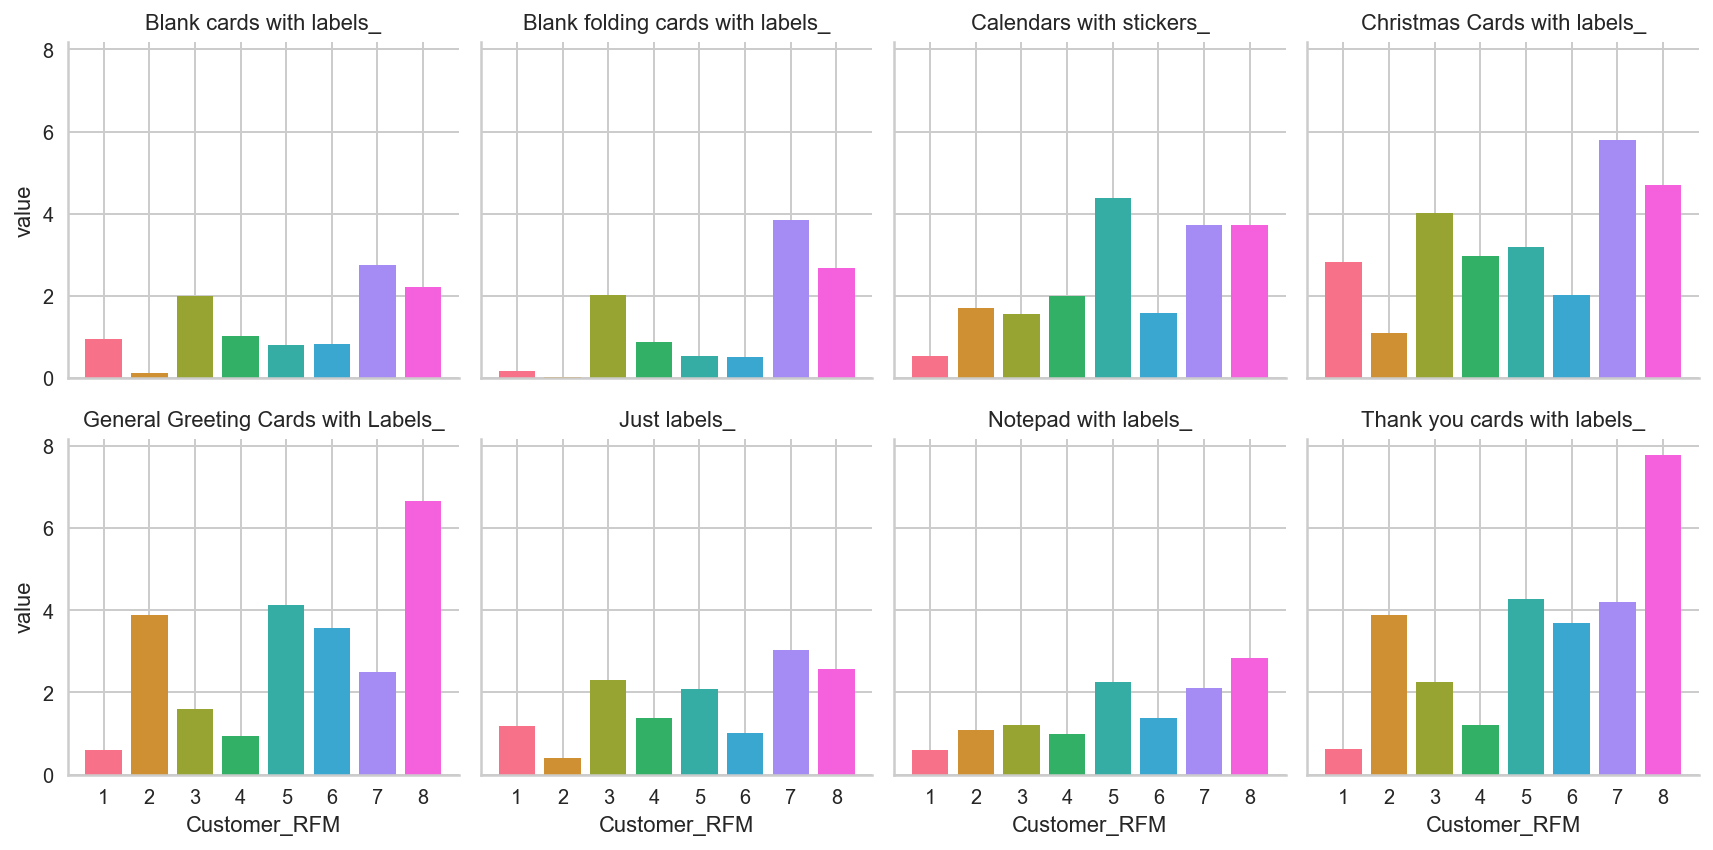

In [298]:
#Gift Card analysis Monetary (taking into consideration the number of campaigns)

gift_analysis = donors_seg_outlier.loc[:,'Just labels':'Notepad with labels'].columns.to_list() + ['Customer_RFM']

gift_prices = donors_seg_outlier[gift_analysis]

gift_prices['Just labels_'] = gift_prices['Just labels']/4 
gift_prices['Calendars with stickers_'] = gift_prices['Calendars with stickers']/2 
gift_prices['Blank folding cards with labels_'] = gift_prices['Blank folding cards with labels']/2 
gift_prices['Blank cards with labels_'] = gift_prices['Blank cards with labels']/4 
gift_prices['Thank you cards with labels_'] = gift_prices['Thank you cards with labels']/2 
gift_prices['General Greeting Cards with Labels_'] = gift_prices['General Greeting Cards with Labels']/2 
gift_prices['Christmas Cards with labels_'] = gift_prices['Christmas Cards with labels']/2
gift_prices['Notepad with labels_'] = gift_prices['Notepad with labels']/4


df = gift_prices.loc[:,'Customer_RFM':].copy()
df = df.reset_index()
df = df.melt(id_vars=['index', 'Customer_RFM'])
df = df.set_index('index', drop = True)
df = df.groupby(['Customer_RFM', 'variable']).mean().reset_index()
g = sns.FacetGrid(df, col='variable', hue='Customer_RFM', col_wrap=4, height=3, sharey=True, legend_out=False)
g = g.map(plt.bar, 'Customer_RFM', 'value').set_titles("{col_name}");

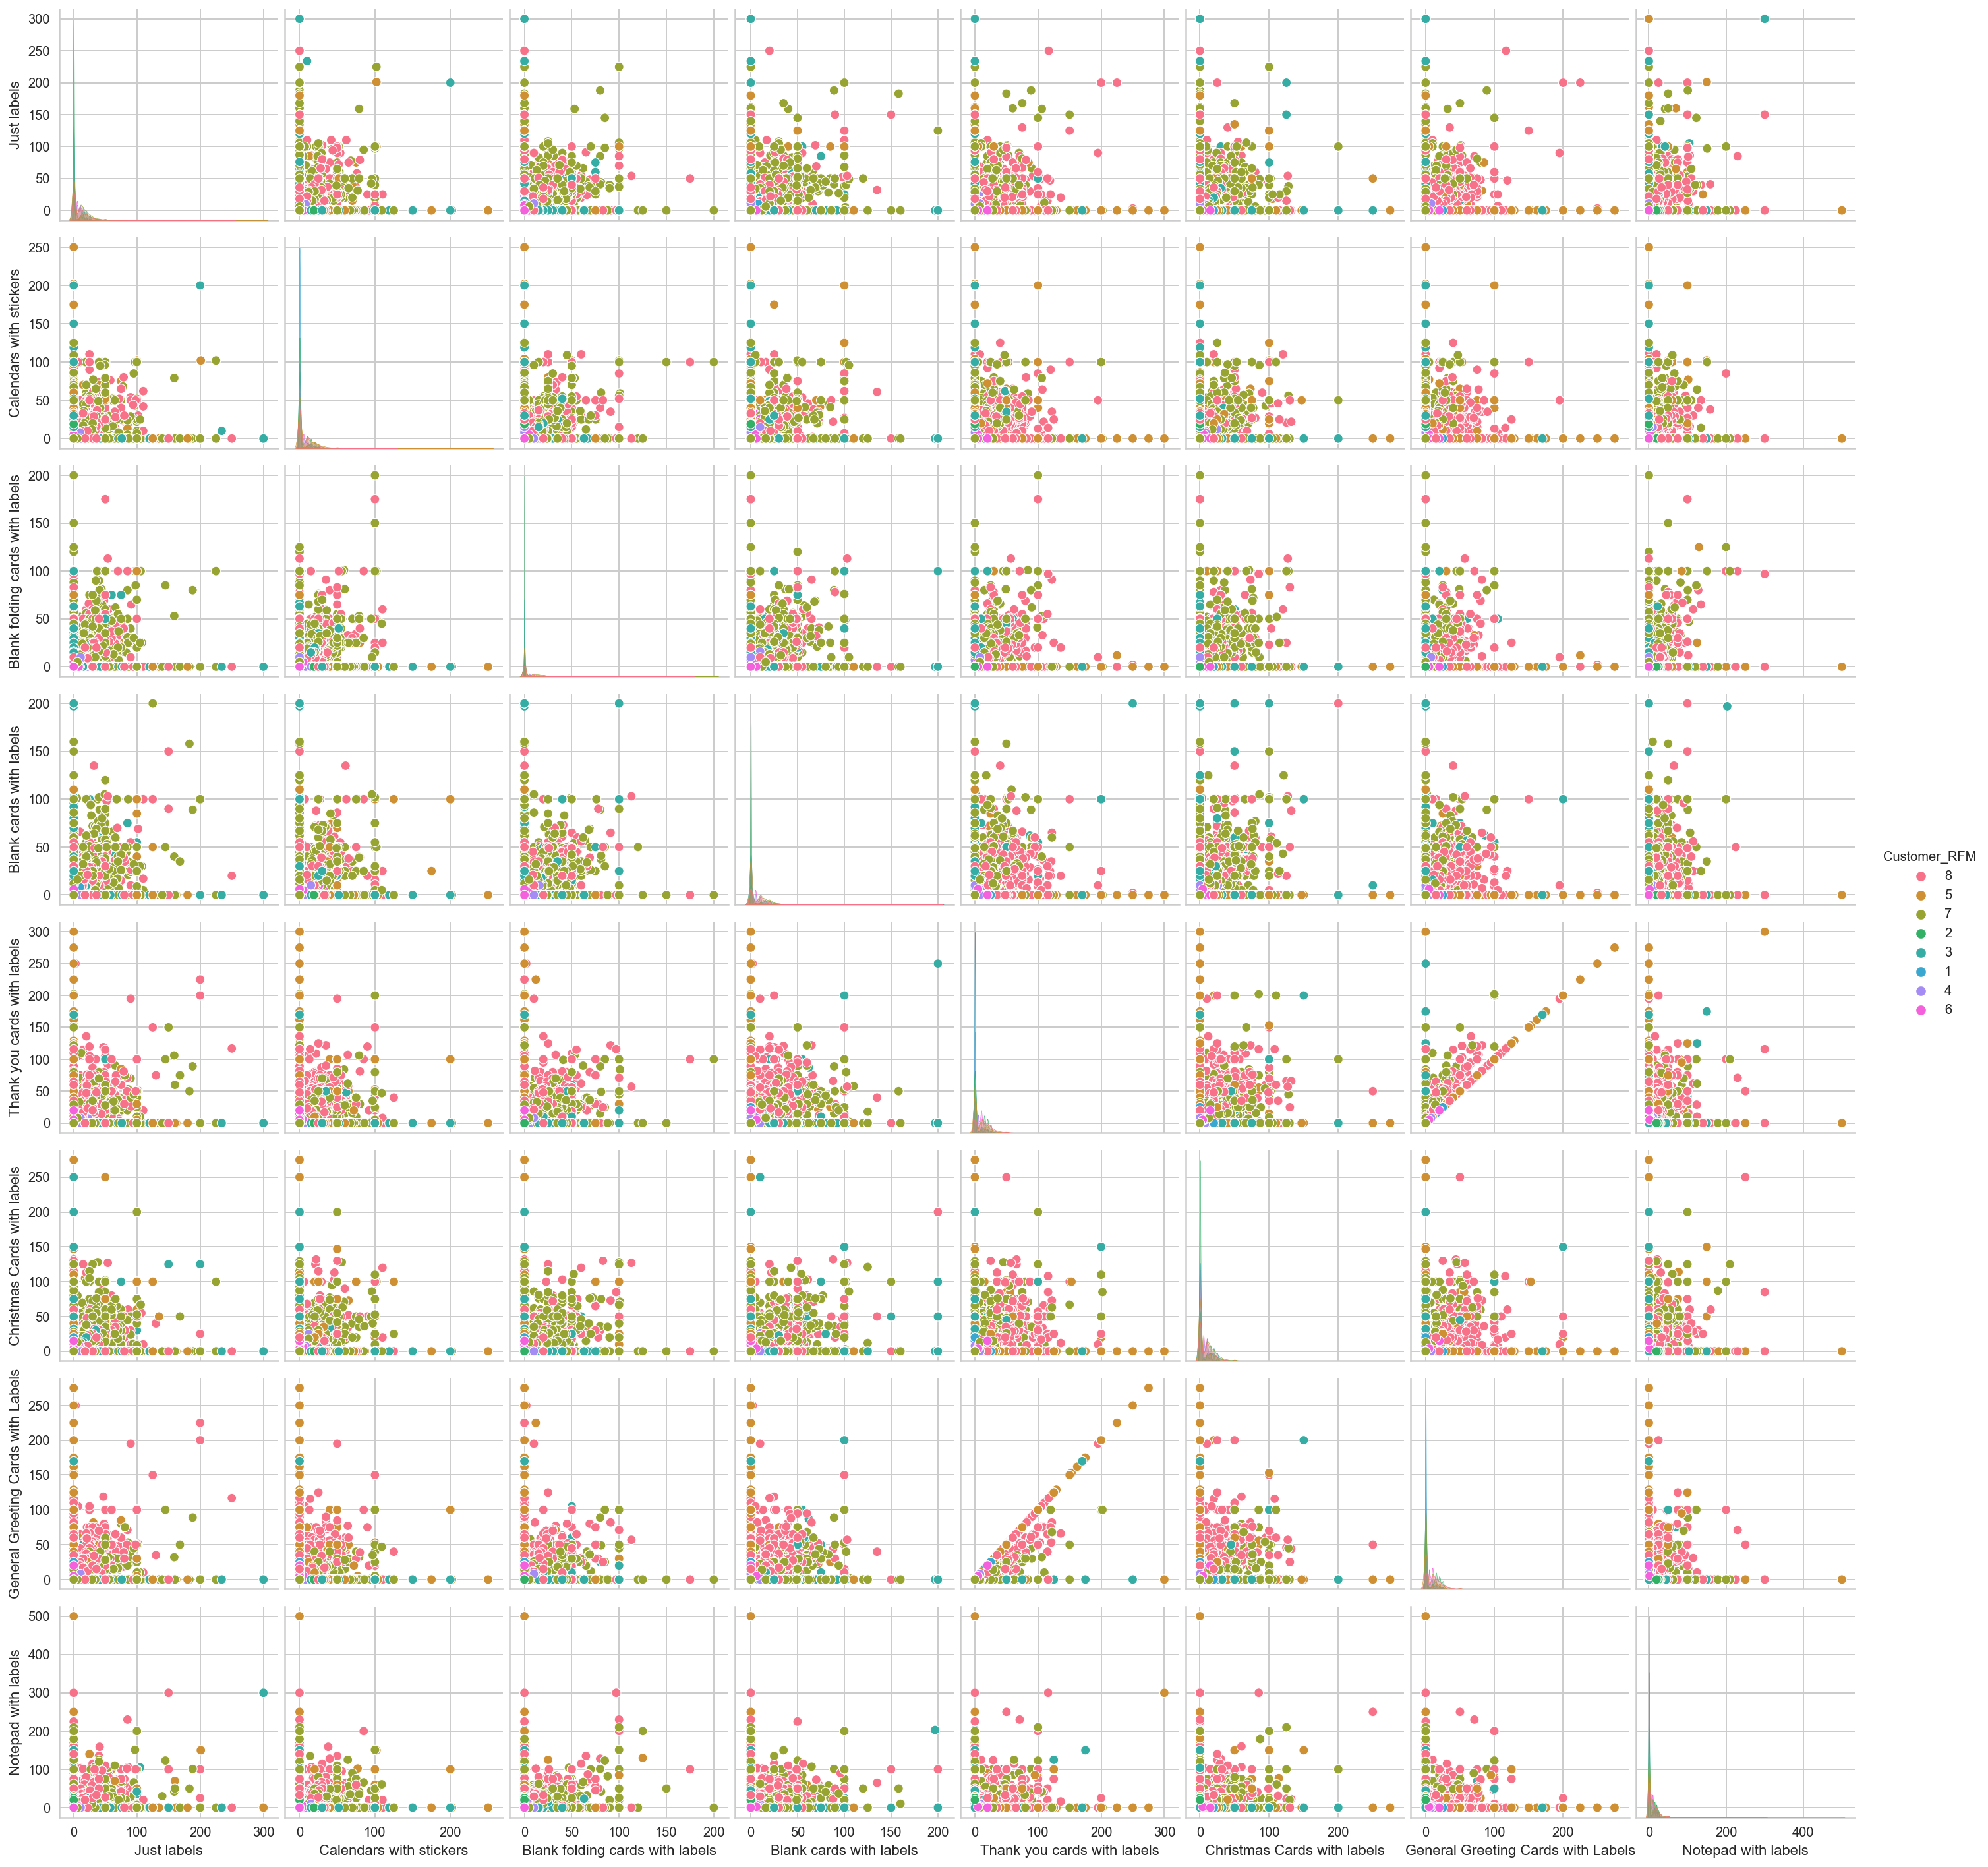

In [299]:
sns.pairplot(donors_seg_outlier[gift_analysis], hue='Customer_RFM')

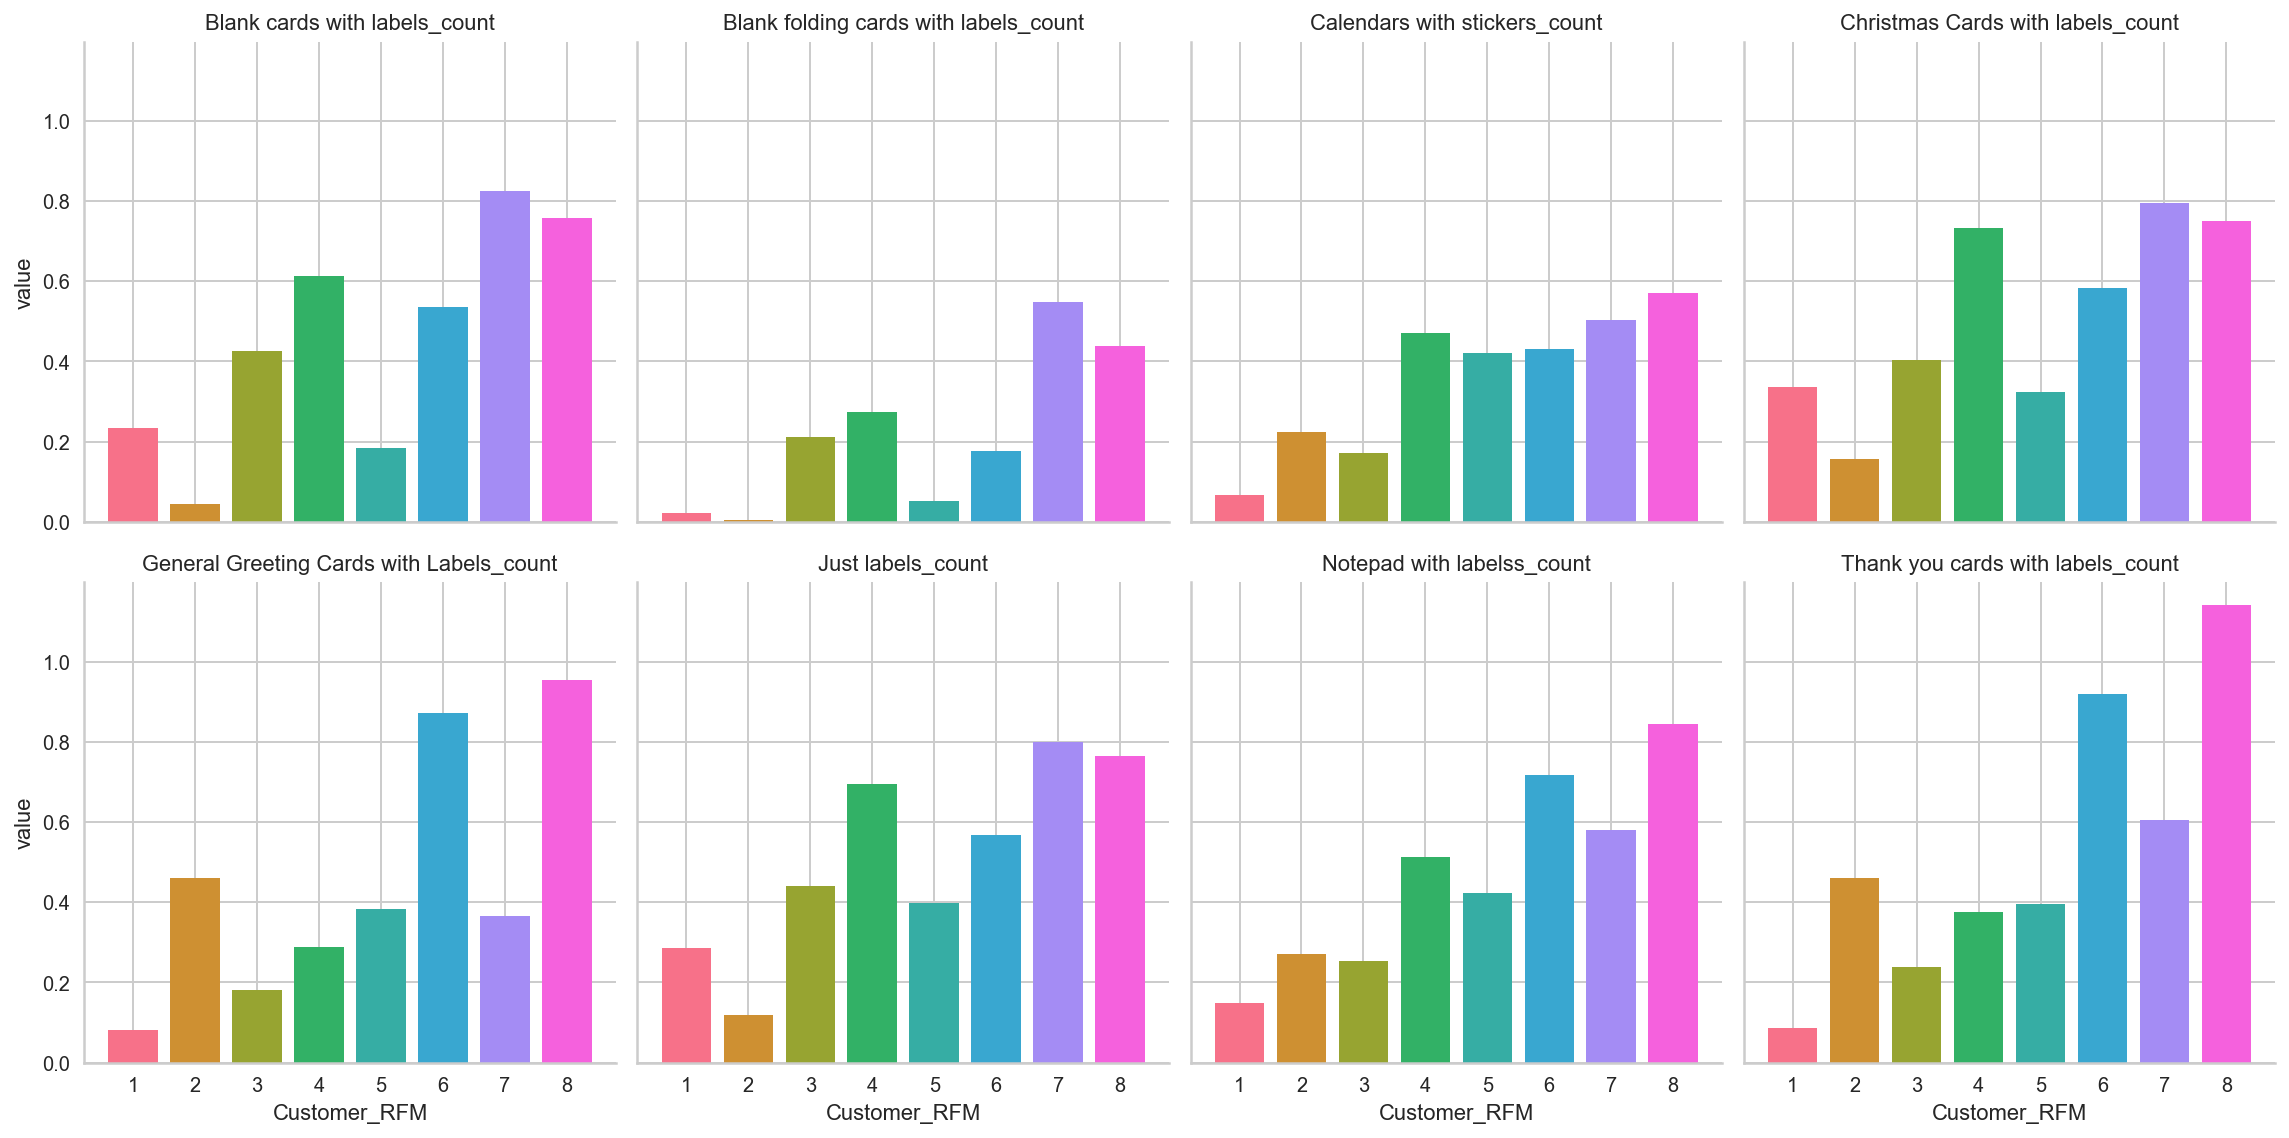

In [300]:
#Gift Card analysis Monetary (total amount)
gift_analysis_count = donors_seg_outlier.loc[:,'Just labels_count':'Notepad with labelss_count'].columns.to_list() + ['Customer_RFM']

df = donors_seg_outlier[gift_analysis_count].copy()
df = df.reset_index()
df = df.melt(id_vars=['index', 'Customer_RFM'])
df = df.set_index('index', drop = True)
df = df.groupby(['Customer_RFM', 'variable']).mean().reset_index()
g = sns.FacetGrid(df, col='variable', hue='Customer_RFM', col_wrap=4, height=4, sharey=True, legend_out=False)
g = g.map(plt.bar, 'Customer_RFM', 'value').set_titles("{col_name}");

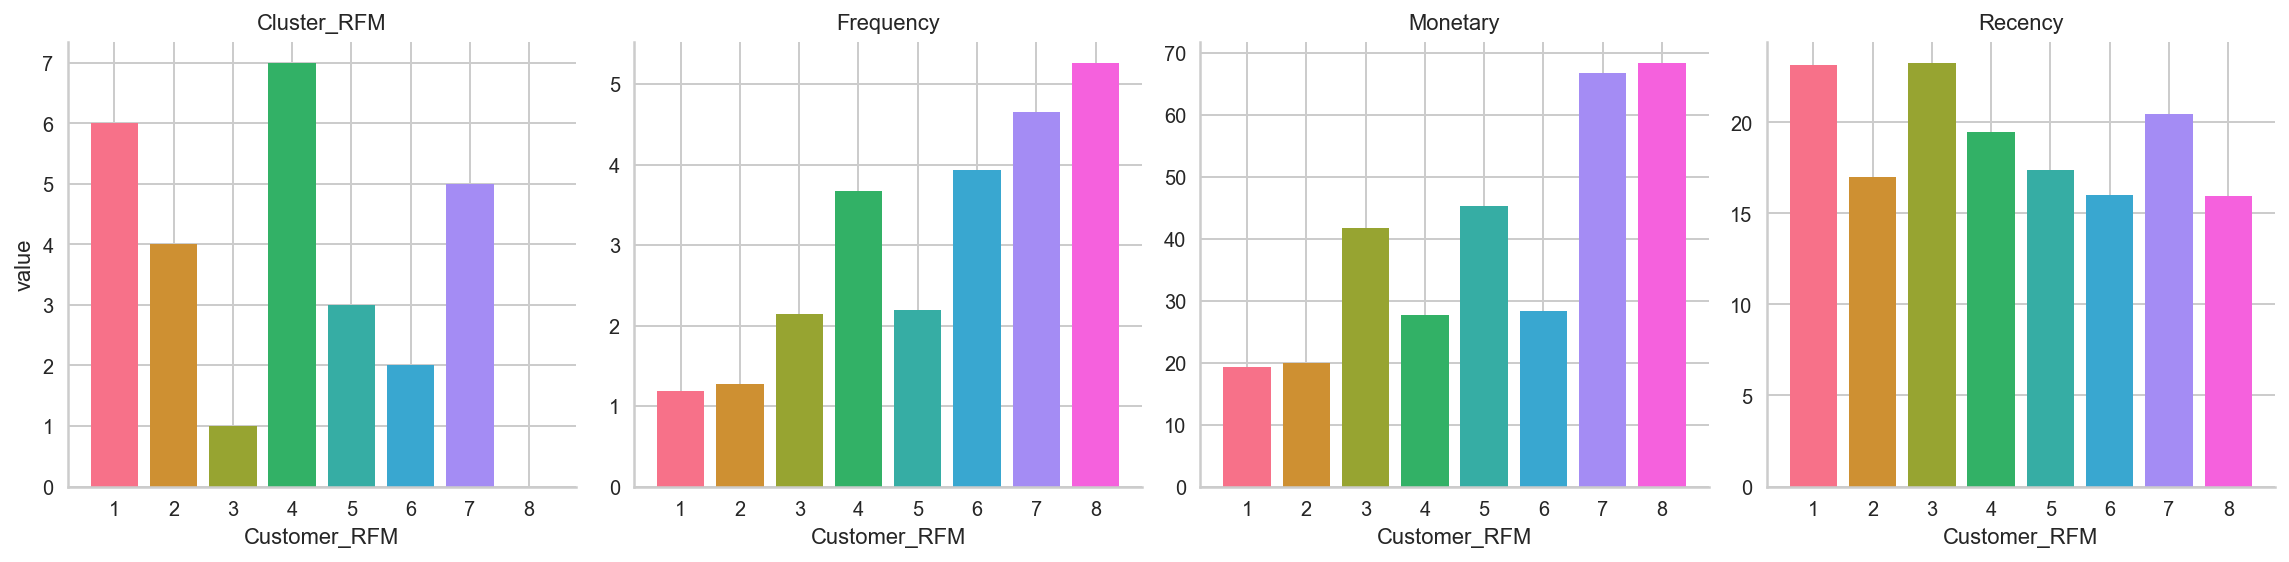

In [301]:
#RFM Analysis
rfm_analysis = donors_seg_outlier.loc[:,['Recency','Frequency', 'Monetary', 'Cluster_RFM']].columns.to_list() + ['Customer_RFM']

df = donors_seg_outlier[rfm_analysis].copy()
df = df.reset_index()
df = df.melt(id_vars=['index', 'Customer_RFM'])
df = df.set_index('index', drop = True)
df = df.groupby(['Customer_RFM', 'variable']).mean().reset_index()
g = sns.FacetGrid(df, col='variable', hue='Customer_RFM', col_wrap=4, height=4, sharey=False, legend_out=False)
g = g.map(plt.bar, 'Customer_RFM', 'value').set_titles("{col_name}");

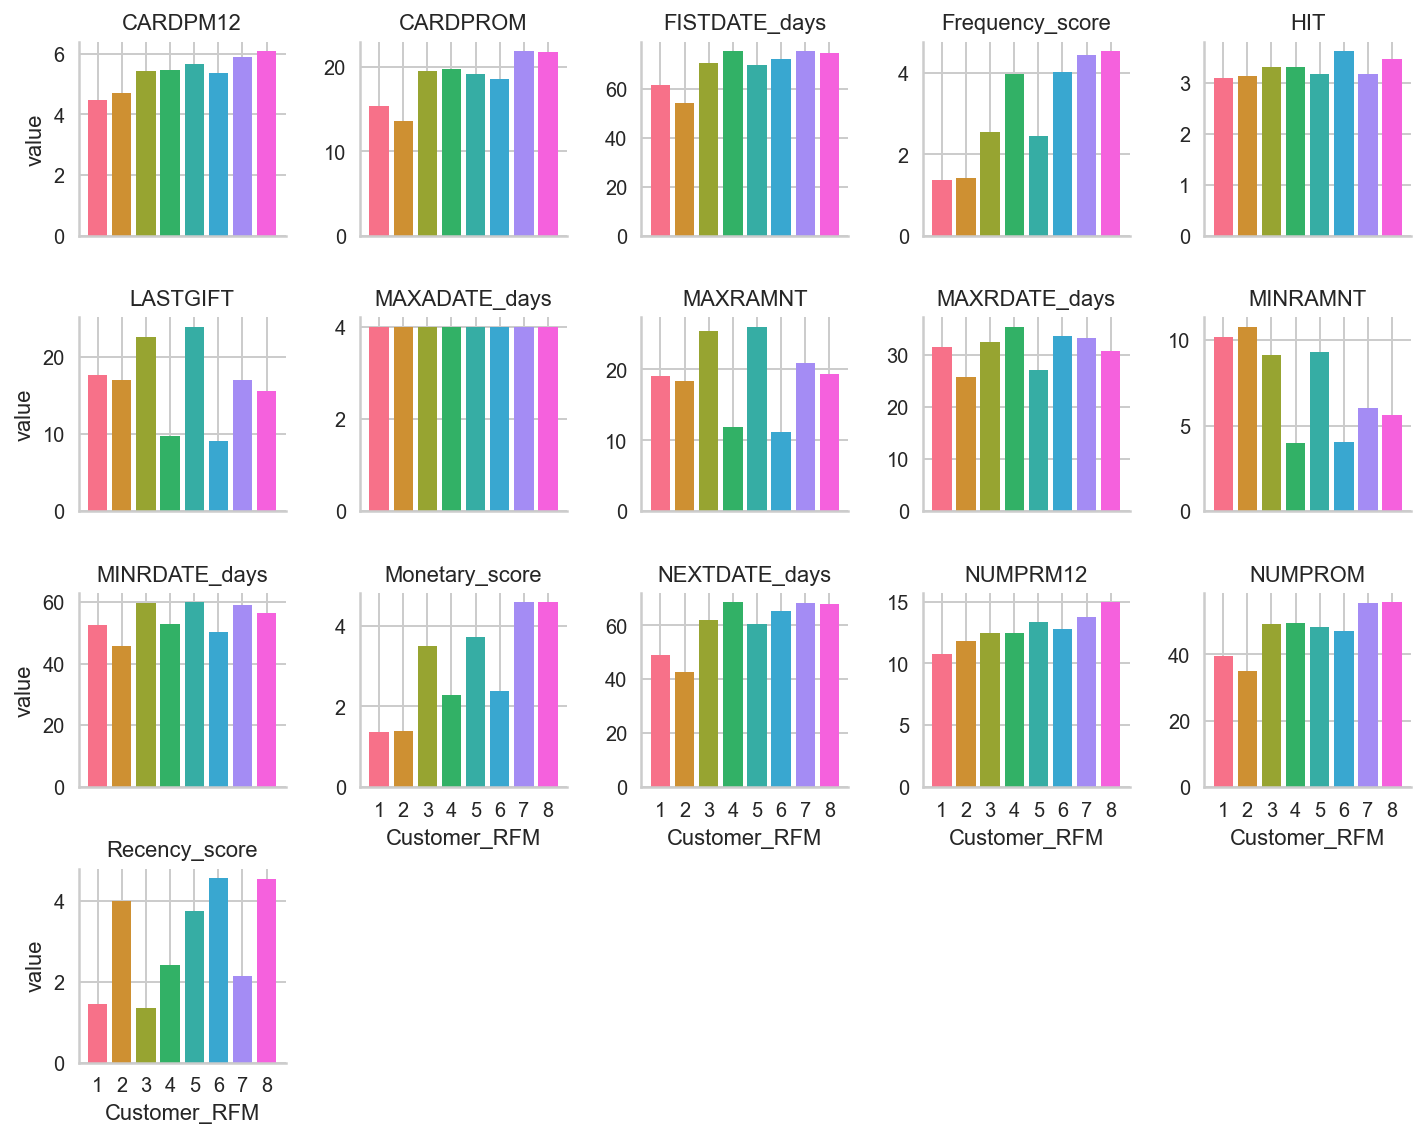

In [302]:
# Donors reactions
donors_hist = donors_seg_outlier.drop(columns = rfm_analysis + gift_analysis_count + gift_analysis + demographic).columns.to_list() + ['Customer_RFM']

df = donors_seg_outlier[donors_hist].copy()
df = df.reset_index()
df = df.melt(id_vars=['index', 'Customer_RFM'])
df = df.set_index('index', drop = True)
df = df.groupby(['Customer_RFM', 'variable']).mean().reset_index()
g = sns.FacetGrid(df, col='variable', hue='Customer_RFM', col_wrap=5, height=2, sharey=False, legend_out=False)
g = g.map(plt.bar, 'Customer_RFM', 'value').set_titles("{col_name}");

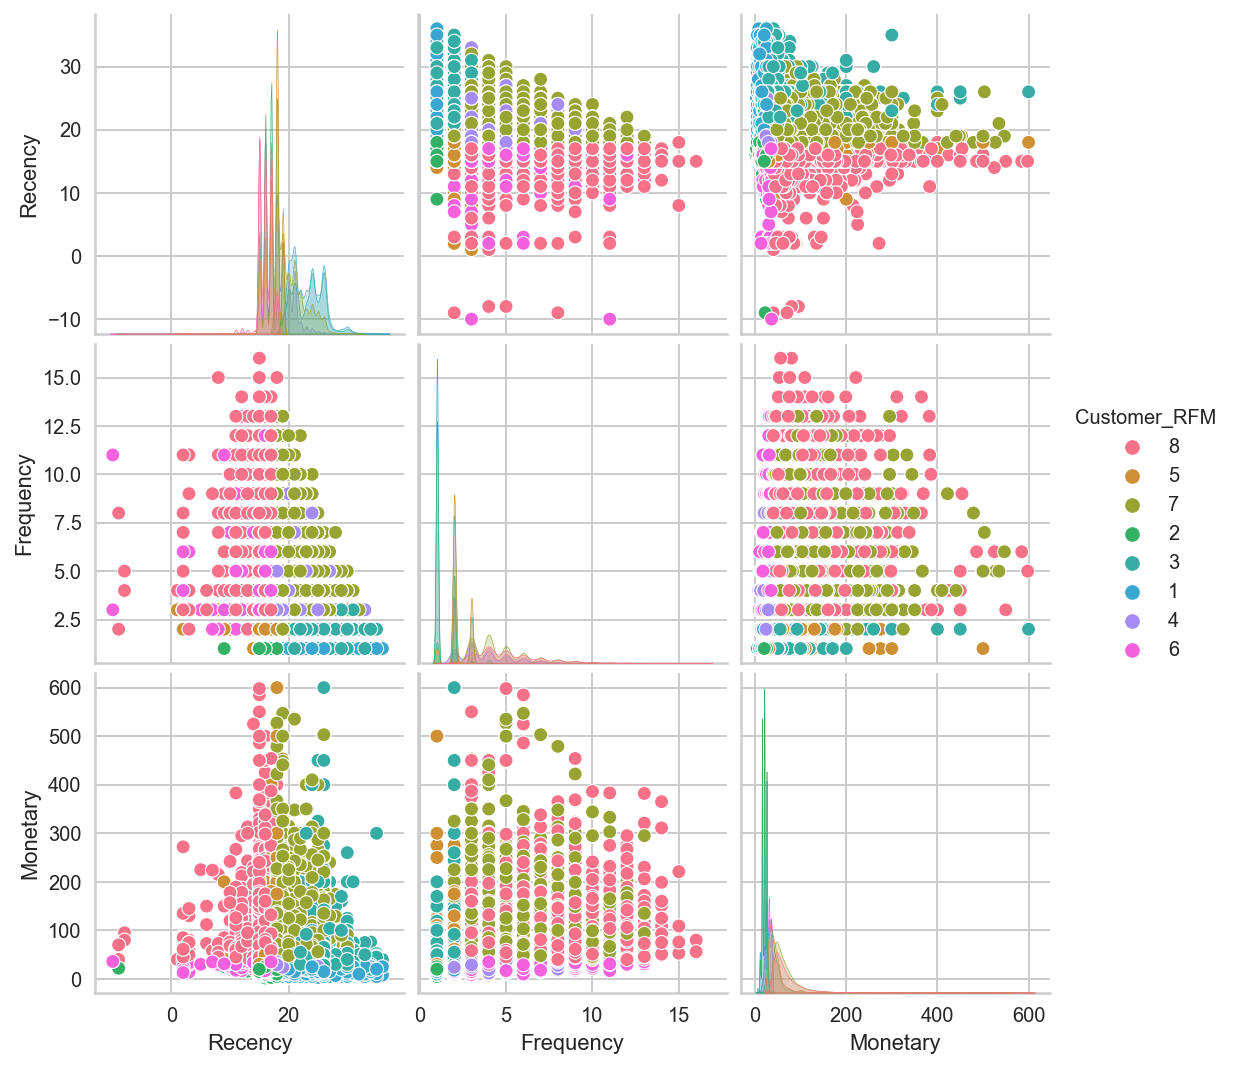

In [303]:
sns.pairplot(donors_seg_outlier.loc[:,['Recency','Frequency', 'Monetary', 'Customer_RFM']], hue='Customer_RFM')

In [276]:
%config InlineBackend.figure_format = 'retina'

Text(0.5, 1.0, 'Total historical value received by type of campaign')

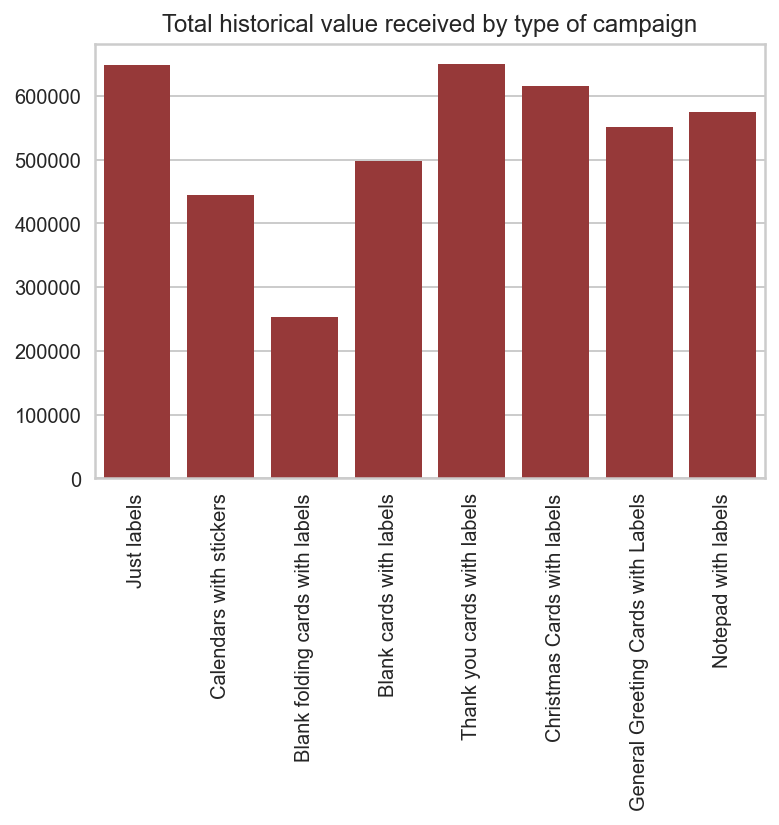

In [293]:
# Total amount of donations received by type of campaign
gifts_sum = donors_seg_outlier[gift_analysis].loc[:,:'Notepad with labels'].sum(axis= 0)
g = sns.barplot(x = gifts_sum.index, y = gifts_sum.values, color = 'brown')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Total historical value received by type of campaign')

In [304]:
RFM_Real = donors_seg_outlier.loc[:,['Recency','Frequency', 'Monetary','Recency_score','Frequency_score', 'Monetary_score','Customer_RFM']].groupby(['Customer_RFM']).agg(['mean'])
RFM_Real['Total'] = RFM_Real.sum(axis = 1)
round(RFM_Real,2)

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,Total
,mean,mean,mean,mean,mean,mean,
Customer_RFM,,,,,,,
1,23.16,1.18,19.28,1.44,1.36,1.36,47.78
2,17.01,1.28,19.86,4.01,1.41,1.40,44.97
3,23.26,2.14,41.73,1.35,2.55,3.50,74.54
4,19.46,3.67,27.63,2.43,3.98,2.28,59.45
5,17.39,2.20,45.29,3.75,2.45,3.73,74.80
6,16.01,3.93,28.39,4.58,4.03,2.39,59.34
7,20.46,4.65,66.76,2.14,4.43,4.59,103.04
8,15.96,5.26,68.35,4.56,4.54,4.59,103.27


In [246]:
# Sum of RFM and the respective Score for every donor
donors_selected.loc[:,['Recency','Frequency','Monetary','Recency_score', 'Frequency_score', 'Monetary_score']].head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score
0,18.0,7.0,73.0,4.0,5.0,5.0
1,18.0,2.0,37.0,4.0,2.0,3.0
2,21.0,7.0,58.0,2.0,5.0,5.0
3,18.0,7.0,65.0,4.0,5.0,5.0
4,17.0,2.0,25.0,4.0,2.0,2.0


Text(0.5, 1.0, 'Value received by type of campaign')

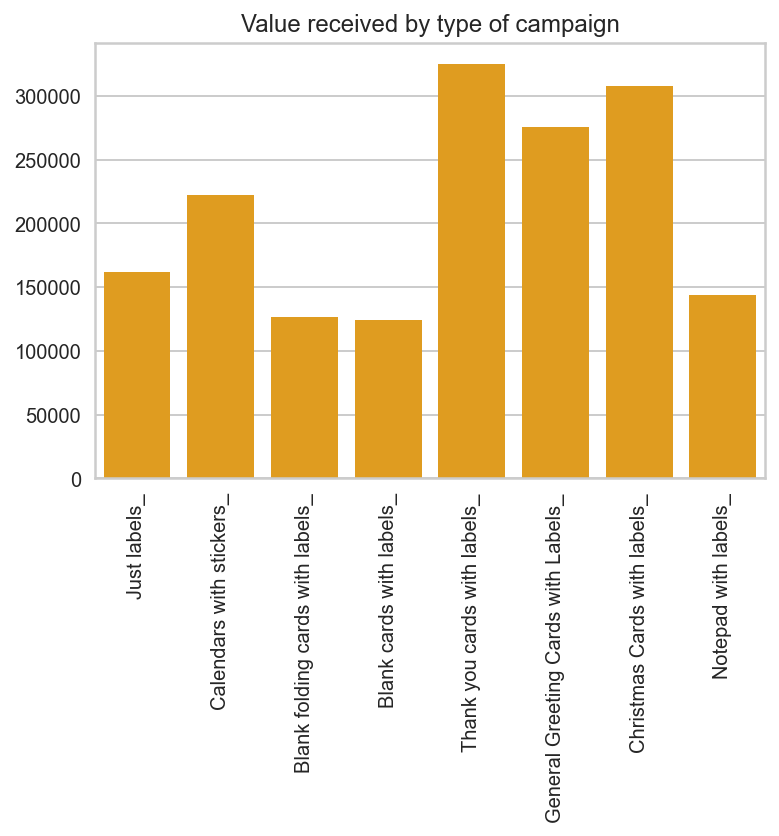

In [294]:
gift_prices = donors_seg_outlier[gift_analysis].loc[:,:'Notepad with labels']

gift_prices['Just labels_'] = gift_prices['Just labels']/4 
gift_prices['Calendars with stickers_'] = gift_prices['Calendars with stickers']/2 
gift_prices['Blank folding cards with labels_'] = gift_prices['Blank folding cards with labels']/2 
gift_prices['Blank cards with labels_'] = gift_prices['Blank cards with labels']/4 
gift_prices['Thank you cards with labels_'] = gift_prices['Thank you cards with labels']/2 
gift_prices['General Greeting Cards with Labels_'] = gift_prices['General Greeting Cards with Labels']/2 
gift_prices['Christmas Cards with labels_'] = gift_prices['Christmas Cards with labels']/2
gift_prices['Notepad with labels_'] = gift_prices['Notepad with labels']/4

gifts_sum = gift_prices.loc[:,'Just labels_':].sum(axis= 0)

%matplotlib inline
%config InlineBackend.figure_format='retina'
g = sns.barplot(x = gifts_sum.index, y = gifts_sum.values, color = 'orange')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Value received by type of campaign')